In [1]:
import tensorflow as tf
import keras

Using TensorFlow backend.


In [63]:
import warnings
warnings.filterwarnings("default",category=DeprecationWarning)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [126]:
pip install pydot

In [127]:
import pydot as pyd
keras.utils.vis_utils.pydot = pyd

In [128]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

In [13]:
# Loading the dataset
df = pd.read_csv(r'C:\Users\ASUS\Downloads\dl_101-master\data\spam.csv', delimiter = ',', encoding = 'latin-1')

In [14]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Text(0.5, 1.0, 'Number of ham and spam messages')

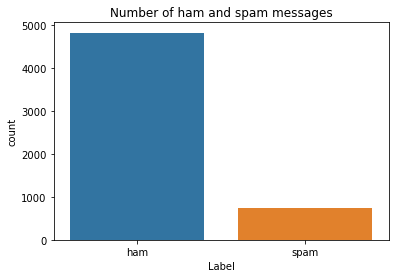

In [17]:
# Understanding data distribution
sns.countplot(df.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [25]:
# Create input and output vectors
Y = df.v1
X = df.v2
le = LabelEncoder()     # sklearn preprocessing object LabelEncoder to encode label
Y = le.fit_transform(Y) # fit and transform Y into encode label
Y = Y.reshape(-1,1)     # reshape value into encode, where -1 for spam and 1 for ham

In [28]:
# Split dataset into training and testing data
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [30]:
X_train.shape

(4736,)

In [31]:
X_test.shape

(836,)

PROCESS THE DATA
- Tokenize the data and convert the text to sequences.
- Add padding to ensure that all the sequences have the same shape.
- There are many ways of taking the max_len and here an arbitrary length of 150 is chosen.

In [32]:
max_words = 1000 # arbitrary set max_words for corpus
max_len = 150    # maximum len for max shape array

In [36]:
tok = Tokenizer(num_words = max_words) # Tokenizer object
tok.fit_on_texts(X_train)              # Update internal vocabulary based on list of texts
sequences = tok.texts_to_sequences(X_train) # Transform each text to a sequence of integers
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [42]:
sequences_matrix

array([[  0,   0,   0, ...,  90,  11, 447],
       [  0,   0,   0, ...,  15,   3, 146],
       [  0,   0,   0, ...,  31,  69,  28],
       ...,
       [  0,   0,   0, ..., 272,   8, 343],
       [  0,   0,   0, ...,   4, 925, 229],
       [  0,   0,   0, ...,   2,   5, 141]])

In [44]:
sequences_matrix.shape # after padding sequences 150 equally

(4736, 150)

In [45]:
for i,k in enumerate(sequences) :
    print(k)
    if i == 5:
        break

[96, 156, 549, 29, 6, 310, 34, 1, 49, 342, 5, 12, 4, 576, 549, 1, 8, 4, 465, 96, 502, 51, 207, 550, 4, 90, 11, 447]
[61, 160, 11, 577, 796, 1, 3, 30, 15, 3, 146]
[1, 66, 248, 1, 30, 31, 69, 28]
[1, 70, 2, 79, 13, 837]
[904, 5, 503, 971, 4, 90, 147, 133, 6, 302, 705, 192, 148, 666, 746]
[132, 278, 11, 134, 86, 143, 9, 17, 4, 55, 80, 178]


In [46]:
# Define the RNN structure
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [76]:
# Call the function and compile the model
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_5 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

In [173]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
           validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',
                                                         min_delta=0.0001)])

Train on 3788 samples, validate on 948 samples
Epoch 1/10
3788/3788 [==============================] - 6s 2ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.1417 - val_accuracy: 0.9905
Epoch 2/10
3788/3788 [==============================] - 6s 2ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.1432 - val_accuracy: 0.9884


In [174]:
# Processing the test set data
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [175]:
# Evaluate the model on the test set
accr = model.evaluate(test_sequences_matrix,Y_test)

836/836 [==============================] - ETA:  - 1s 665us/step


In [176]:
print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
 Loss: 0.379
 Accuracy: 0.980
